<a href="https://colab.research.google.com/github/Ulugbek9403/ml_edu/blob/master/notebooks/31_ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Поговорим об алгоритмах!

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==2.2.2, scikit-learn==1.4.2, matplotlib==3.8.4`

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2 matplotlib==3.8.4`


## Содержание

* [KNN - K-Nearest-Neighbours](#KNN---K-Nearest-Neighbours)
* [Decision tree - деревья решений](#Decision-tree---деревья-решений)
* [Ансамблирование](#Ансамблирование)
  * [Bootstrap - бутстрап](#Bootstrap---бутстрап)
  * [Random Forest - Случайный лес](#Random-Forest---Случайный-лес)
  * [Boosting - бустинг](#Boosting---бустинг)
  * [Stacking - стэкинг](#Stacking---стэкинг)
* [Вопросы для закрепления](#Вопросы-для-закрепления)
* [Полезные ссылки](#Полезные-ссылки)


Привет! Сегодня нужно разобраться и освоить принципы работы разных базовых алгоритмов машинного обучения.

In [1]:
# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

sns.set_style("darkgrid")

# Зафиксируем состояние случайных чисел
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


До этого момента мы работали только с линейными моделями, принцип которых заключался в том, чтобы присвоить каждой колонке вес вместе с отступом (bias) и получить предсказание.

В задаче регрессии это и было предсказанием, а вот в задаче классификации такое сырое значение называется **logits**, который нужно было обработать через sigmoid (бинарная) или softmax+argmax (мультиклассовая), чтобы привести это к вероятности присвоения классу и дальше принимать решение.

Важно понимать, что линейные алгоритмы в классификации могут разделять прямыми линиями, а данные могут иметь крайне нелинейные зависимости, например, такую:

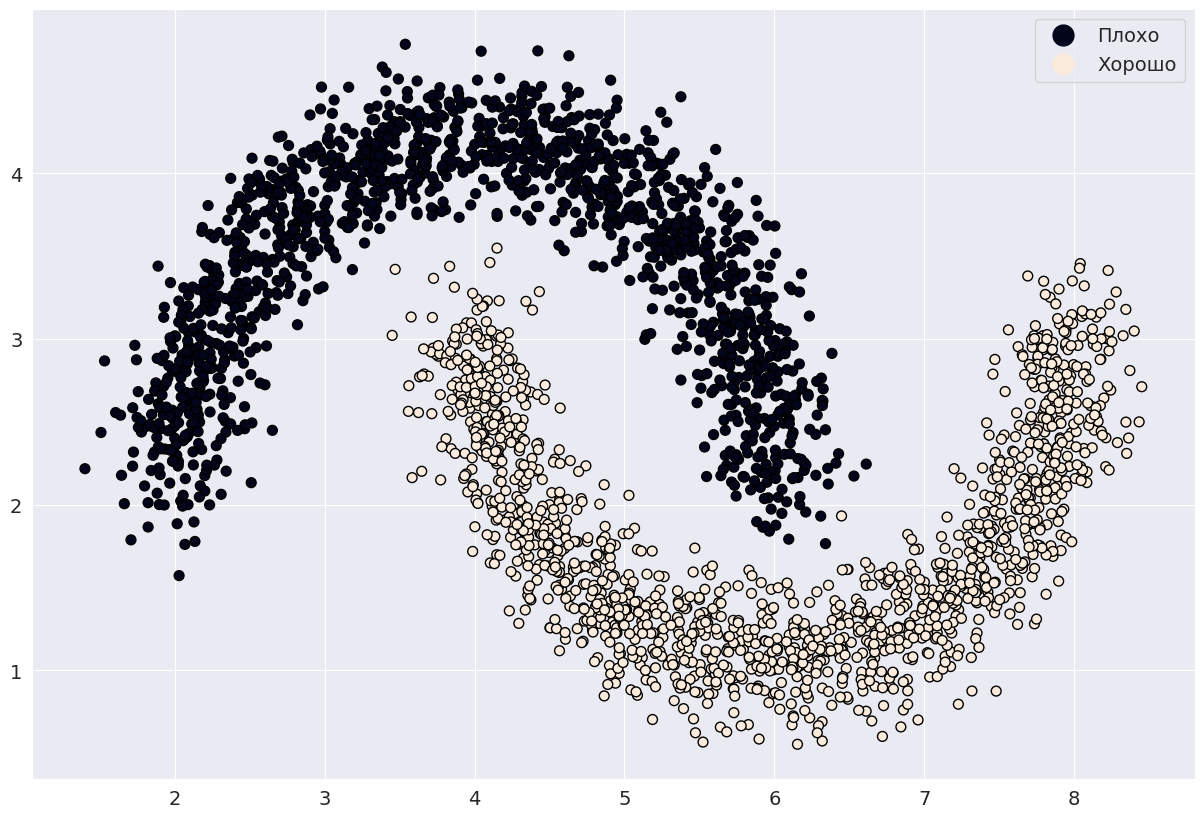

In [2]:
from sklearn.datasets import make_moons

X_data, y_data = make_moons(n_samples=3000, random_state=RANDOM_SEED, noise=0.1)
X_data += np.array([2,1]).reshape(1, -1)
X_data *= np.array([2,2.1]).reshape(1, -1)

df_data = pd.DataFrame(X_data, columns=["x1", "x2"])
df_data["target"] = y_data

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker="o", c=y_data, s=50, edgecolor="k")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=["Плохо", "Хорошо"])
plt.show()

Так как мы уже рассмотрели много разных задач, а сейчас нам нужно понять принципы работы алгоритмов, то это просто какие-то анонимные данные, которые имеют два класса. Цель - предсказать эти классы.

> Для упрощения классы сразу представлены числами, но вы уже умеете кодировать целевые классы.

In [3]:
df_data.head(10)

x1        x2  target
0  4.122195  1.789739       1
1  2.214562  3.303116       0
2  4.686900  1.775995       1
3  5.654070  3.151000       0
4  6.939374  1.329792       1
5  2.715611  3.793112       0
6  2.234561  2.917049       0
7  5.549493  1.604587       1
8  5.157015  4.123883       0
9  7.197868  1.471913       1

Как мы уже говорили, линейные модели, с которыми вы работали, не позволяют сделать корректное разделение, так как данные имеют больее сложный характер.

Давайте попробуем это сделать и визуализируем плоскость предсказаний:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df_train, df_test = train_test_split(df_data, test_size=0.3, random_state=RANDOM_SEED, stratify=df_data.target)

logreg = LogisticRegression(random_state=RANDOM_SEED)
y_train = df_train.target
y_test = df_test.target
x_columns = ["x1", "x2"]
x_train = df_train[x_columns]
x_test = df_test[x_columns]

logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       450
           1       0.89      0.90      0.90       450

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



In [5]:
def visualize_predictions(model, df_train, df_test):
    _, ax = plt.subplots(ncols=2, figsize=(25,9), sharex=True, sharey=True)

    df_train = df_train.copy()
    y = df_train.pop("target")
    X = df_train.values

    x1_off = 0.2
    x2_off = 0.2

    x1_vals = np.linspace(X[:,0].min()-x1_off, X[:,0].max()+x1_off, 100)
    x2_vals = np.linspace(X[:,1].min()-x2_off, X[:,1].max()+x2_off, 100)
    xx, yy = np.meshgrid(x1_vals, x2_vals)
    y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    y_pred = y_pred.reshape(xx.shape)

    ax[0].contourf(xx, yy, y_pred)
    ax[0].scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="k")
    ax[0].set_title("Train")

    df_test = df_test.copy()
    y = df_test.pop("target")
    X = df_test.values

    ax[1].contourf(xx, yy, y_pred)
    ax[1].scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="k")
    ax[1].set_title("Test")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


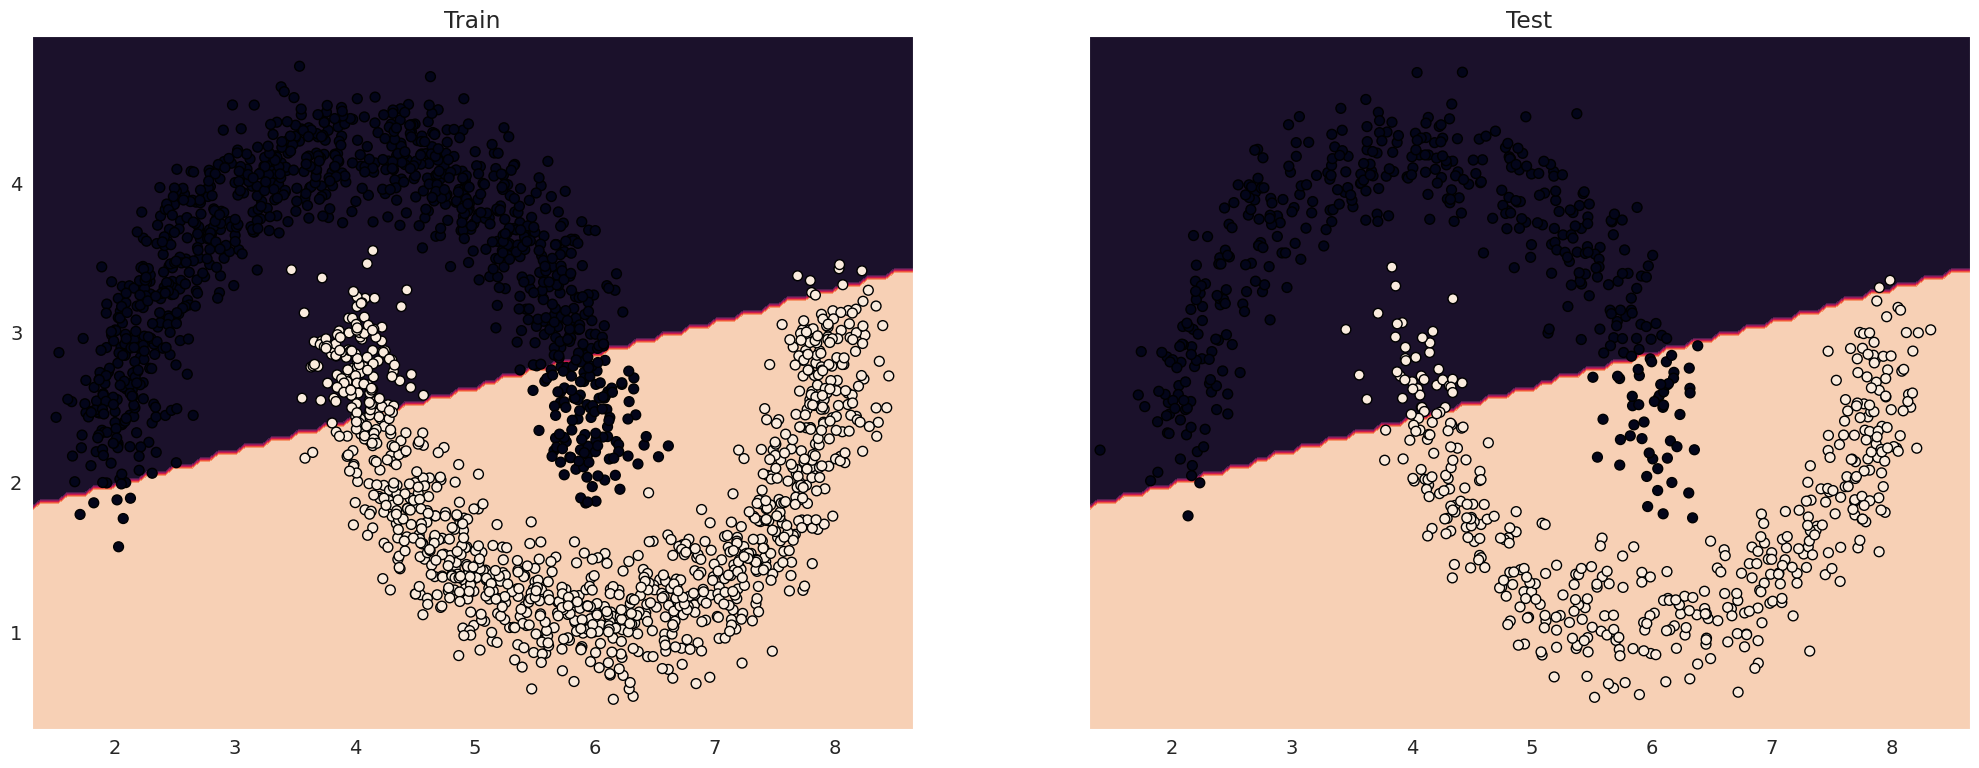

In [6]:
visualize_predictions(logreg, df_train, df_test)

Как видите, линейный алгоритм хоть и работает с высокими показателями метрик, но не описывает зависимости, по которой можно почти идеально разделить данные, так как эти зависимости нелинейны.

Давайте начнём с очень простого алгоритма, который основывается на очень простых принципах!

## KNN - K-Nearest-Neighbours

Представьте, мы взяли тренировочные данные, запомнили их и дальше используем для предсказания следующим образом:
- новые данные (точка в пространстве признаков) приходят - новая запись;
- по евклидову расстоянию L2 ($L2 = \sqrt{(x_1-x_{1new})^2+(x_2-x_{2new})^2}$) смотрим ближайшие точки;
- находим 5 (K) ближайших точек;
- смотрим на их классы;
- поскольку количество нечётное, то какого-то класса будет больше - его и присваиваем новой записи.

Вот таким нехитрым способом мы делаем предсказания с помощью алгоритма KNN. Давайте посмотрим на картинках:

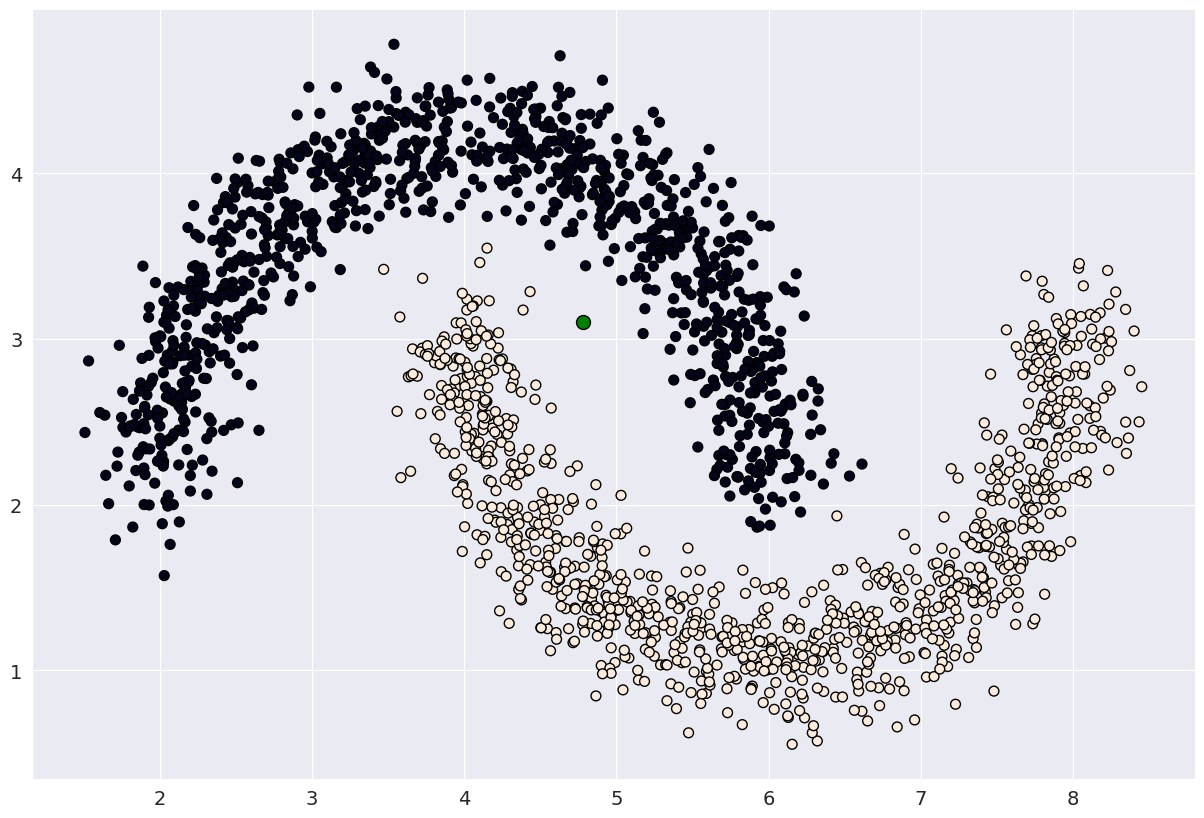

In [7]:
_plot_y = df_train.target
_plot_x = df_train[x_columns].values

_new_point_x = np.array([4.78, 3.1]).reshape(1, -1)

plt.scatter(_plot_x[:, 0], _plot_x[:, 1], marker="o", c=_plot_y, s=50, edgecolor="k")
plt.scatter(_new_point_x[:, 0], _new_point_x[:, 1], marker="o", s=100, edgecolor="k", c="g")
plt.show()

Вот мы видим зеленую новую точку - нам нужно сделать предсказание и определить класс для новых данных. Давайте посмотрим, как это делаем визуально:

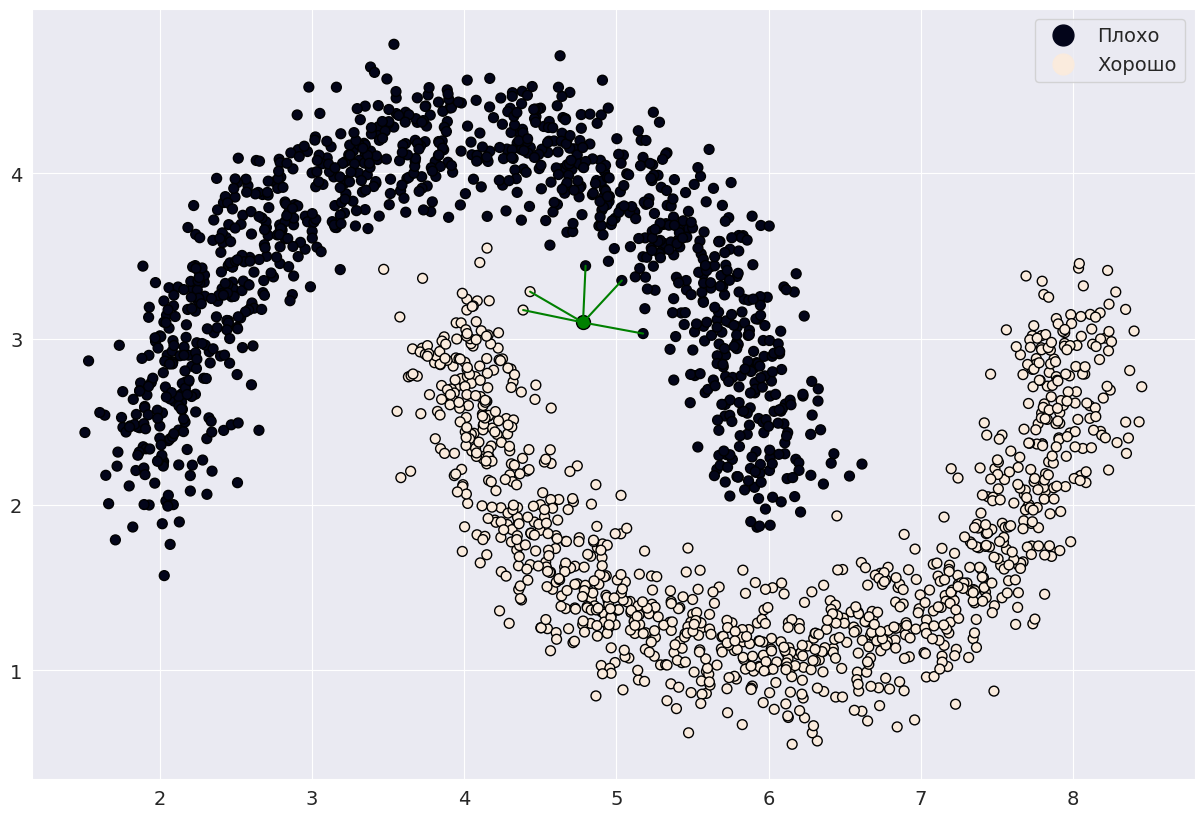

In [8]:
from scipy.spatial.distance import cdist

dist_mtrx = cdist(_plot_x, _new_point_x)
dist_vec = dist_mtrx.reshape(-1)
indexes = np.argsort(dist_vec)[:5]

plt.scatter(_plot_x[:, 0], _plot_x[:, 1], marker="o", c=_plot_y, s=50, edgecolor="k")
plt.scatter(_new_point_x[:, 0], _new_point_x[:, 1], marker="o", s=100, edgecolor="k", c="g")

for pnt, cls_ in zip(_plot_x[indexes], _plot_y.iloc[indexes]):
    x1, y1 = pnt
    x2, y2 = _new_point_x[0]

    plt.plot([x1, x2], [y1, y2], color="g")

plt.legend(handles=pnts_scatter.legend_elements()[0], labels=["Плохо", "Хорошо"])
plt.show()

Вот мы нашли 5 ближайших соседей, 2 класса "Хорошо", а 3 - класса "Плохо". Значит, предсказание модели KNN будет - класс "Плохо"!

Вот таким незамысловатым образом работает модель, которая ещё и является нелинейной!

Давайте посмотрим на метрики и пространство предсказания:

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      1.00      1.00       450

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


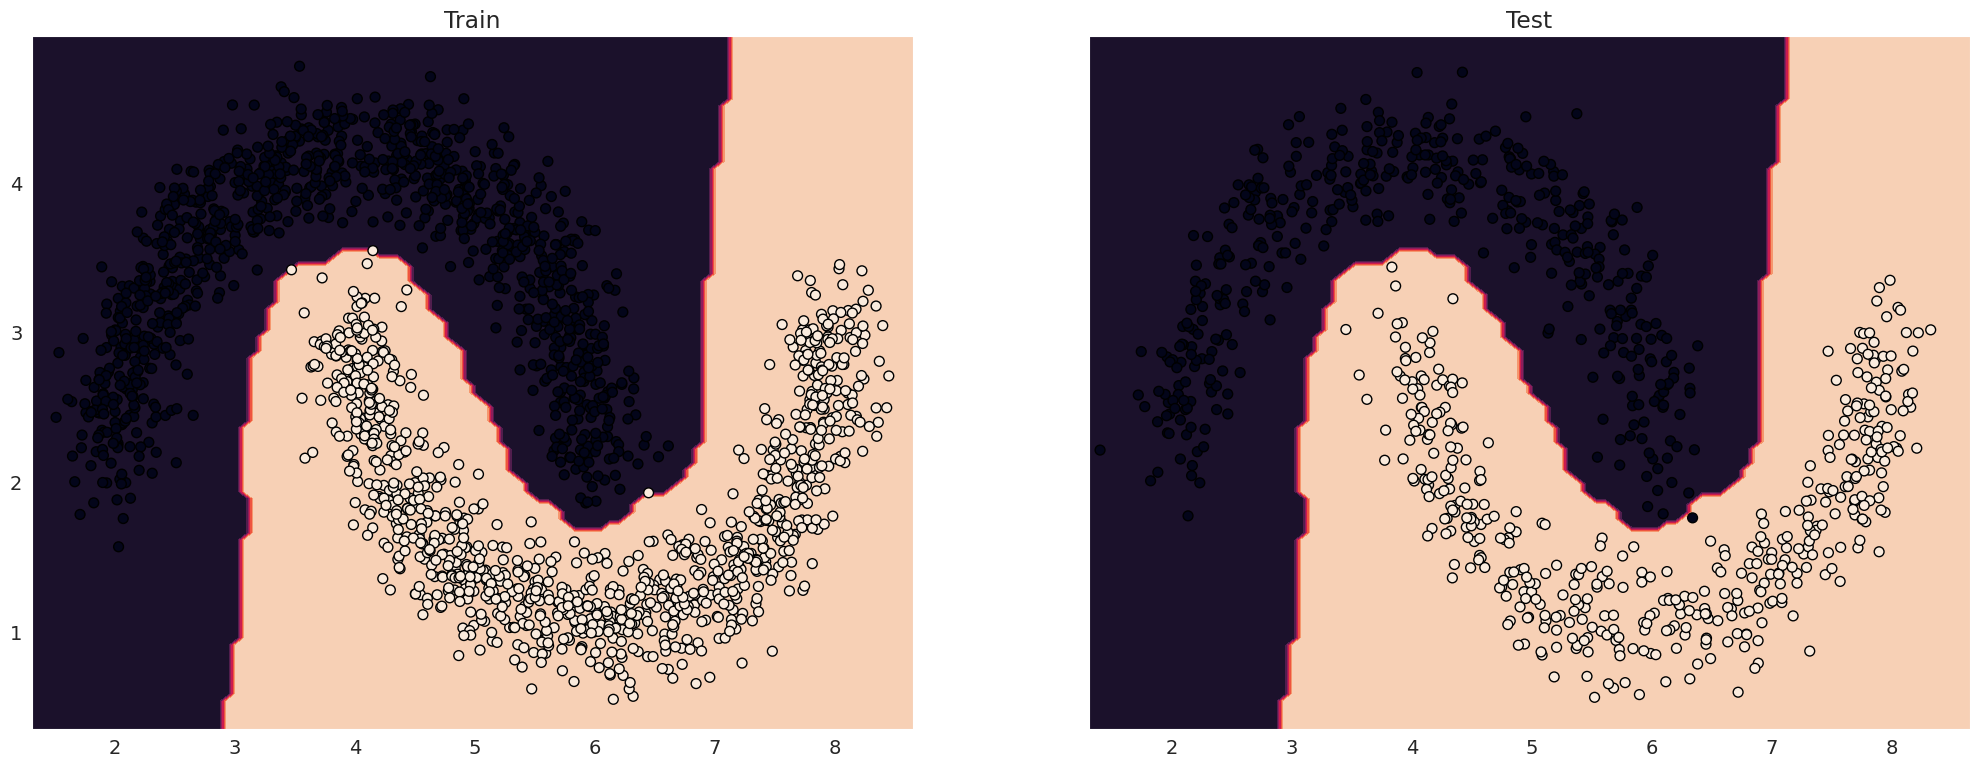

In [10]:
visualize_predictions(knn, df_train, df_test)

Смотрите-ка! Модель не только предсказала всё идеально, так ещё и отлично разделила пространство в соответствии с данными! Вот что может нелинейная модель!

Так почему же сегодня все не применяют такую прекрасную вещь? Это же идеально!

На самом деле есть три большие проблемы:
1. Алгоритм по сути не обучается, вычисляя более компактное представление (например, в виде весов для признаков в LogReg), а хранит все данные в памяти. В нашем случае это работает, но понятие **большие данные** (**BigData**) базируется на объёмах данных, которые не получается хранить на одной машине, не говоря уже про то, чтобы это просто загрузить в память. Поэтому, по памяти алгоритм крайне неоптимален.
2. Для предсказания нам нужно новую точку сравнить со всеми в массиве для обучения - это очень затратная операция, хоть и оптимизируемая! Например, с помощью KDTree. (Об этом можете самостоятельно почитать).
3. В случае идеального разделения - всё хорошо, но при пересечении кластеров и сильном шуме, алгоритм из-за запоминания может переобучиться.

Тем не менее, вы видите, что он очень прост в понимании, а это очень важно в разработке, иметь инструменты, которые хорошо понимаешь и можешь уверенно использовать!

Ещё, обратите внимание, в конструкторе модели есть параметр `n_neighbors`, который нужно настраивать! Как нам это делать? Наверное, можно попробовать перебрать нечётные значения и оценивать на тестовой выборке метрику? Тогда, лучший вариант мы и оставим, но ... стоп ...

Если мы использовали тестовую выборку для подбора параметра модели - мы как бы "неявно обучали модель"? Мы же теперь не знаем, как конечная модель будет работать на новых данных? Уфф, давайте-ка разберёмся!

> 🤓 **Параметры модели** - это те параметры, которые настраиваются в ходе автоматического обучения (weights, bias)

> 🤓 **Гиперпараметры модели** - параметры, которые не настраиваются в ходе автоматического обучения, но влияют на принцип работы модели и могут настраиваться инженером (количество соседей в KNN, порог принятия решения в LogReg бинарной классификации)

Получается, что модель в ходе обучения сама настраивает **параметры** и делает это с помощью своих метрик на обучающей выборке, а мы можем менять **гиперпараметры**, которые тоже влияют на результаты, и их надо настраивать по метрикам (неявное обучение - **indirect learning**), но если мы будем делать это на тестовой, то у нас не будет выборки, чтобы сделать конечную оценку! Что делать?

На этот и на много других вопросов про настройку параметров давайте поговорим в следующий раз, а пока просто помните, что это **очень важная** проблема! С этой поры просто train-test не обойтись!

## Decision tree - деревья решений

Теперь вернёмся к разделению точек прямыми линиями, но скажем, что *делить мы можем несколько раз* и *по горизонтали и вертикали*.

> 🤓 Правильнее сказать, что делить можем прямой линией по каждому признаку в пространстве признаков. По сути простой *порог по значению*.

Тогда получается, если наши данные имеют вид:

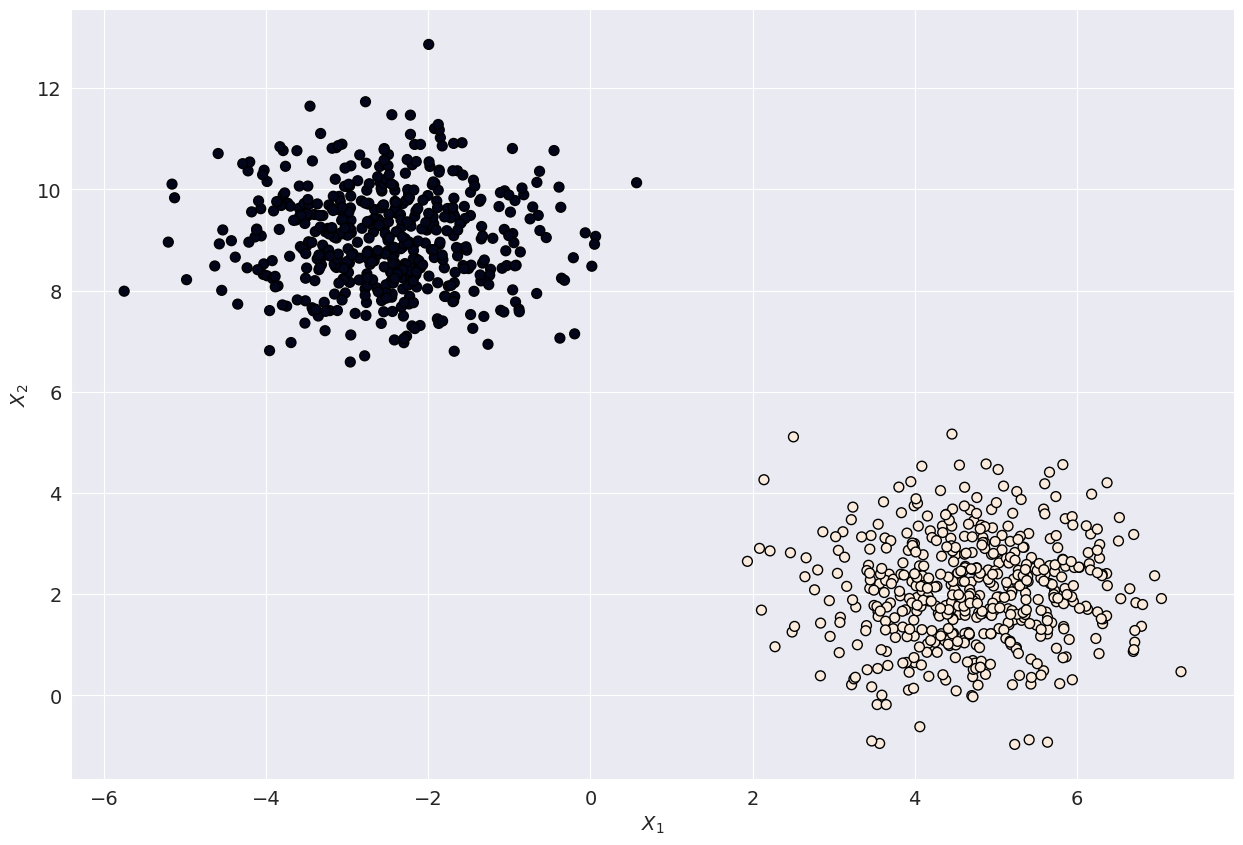

In [11]:
from sklearn.datasets import make_blobs

_sample_X_data, _sample_y_data = make_blobs(
    n_samples=1000,
    centers=2,
    random_state=RANDOM_SEED
)

plt.scatter(_sample_X_data[:, 0], _sample_X_data[:, 1], marker="o", c=_sample_y_data, s=50, edgecolor="k")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

То мы можем взять значение 1 по признаку $X_1$, разделить по нему и сказать, что если значение $X_1$ больше 1, то это класс 1, в ином случае - класс 2.

Это основной принцип, по которому работает дерево решений. Давайте обучим модель для этого случая и посмотрим на картинки:

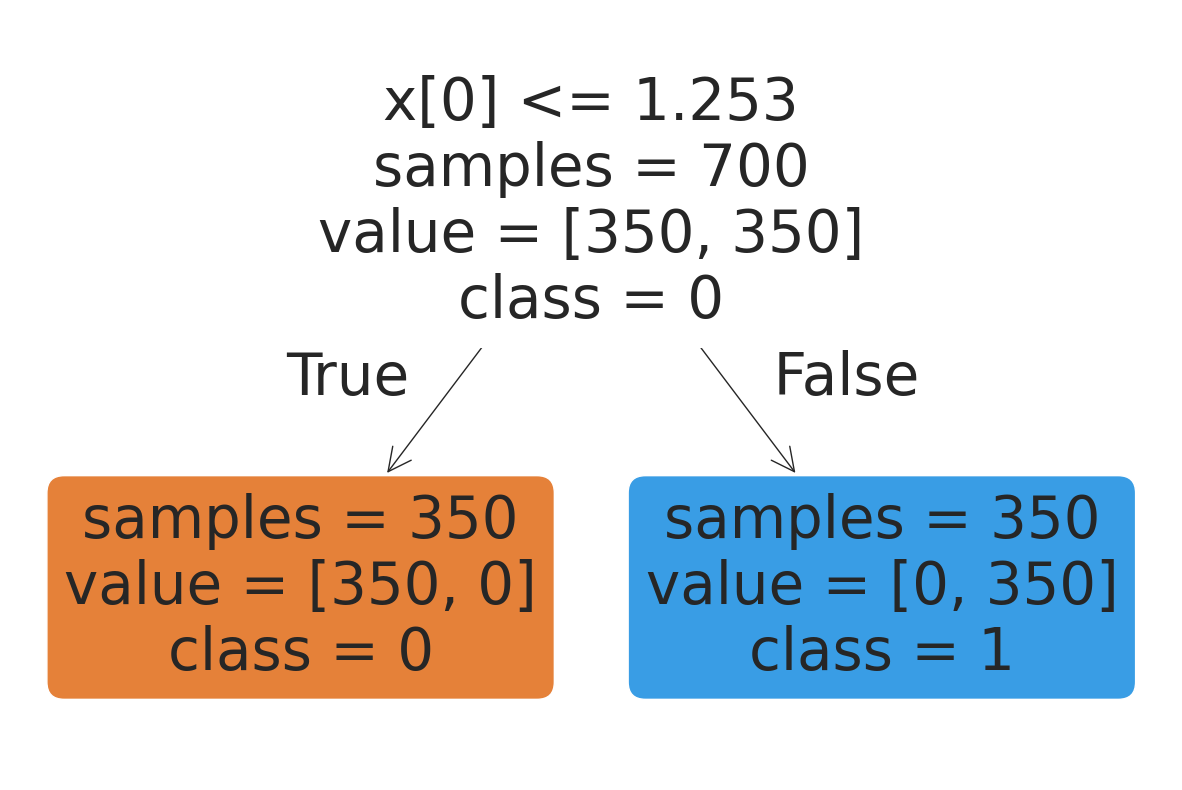

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

_smpl_X_train, _smpl_X_test, _smpl_y_train, _smpl_y_test, = train_test_split(_sample_X_data, _sample_y_data, random_state=RANDOM_SEED, stratify=_sample_y_data, test_size=0.3)

dectree = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_SEED)

dectree.fit(_smpl_X_train, _smpl_y_train)

_ = plot_tree(dectree, filled=True, rounded=True, impurity=False, class_names=["0", "1"])

Видите, это дерево решения. Оно состоит из:
- узла разделения (место, где запоминается, по какому признаку какой порог), в котором по $X_1$ (на картинке это X[0]) выбран порог 1.253;
- двух листов:
    - левый, если значение $X_1$ меньше или равно 1.253, то выбирается оранжевый лист и предсказываетрся класс 0;
    - правый, если значение $X_1$ больше 1.253, то выбирается синий лист и предсказываетрся класс 1.

По сути, дерево решений состоит из множества узлов и заканчивается кучей листов. Мы сейчас задали глубину 1, так как мы видим, что данные можно разделить с помощью единственного разделения, но давайте вернемся к нашим данным и попробуем глубину побольше, например три:

In [13]:
dectree = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_SEED)

dectree.fit(x_train, y_train)

y_pred = dectree.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       450
           1       0.87      0.99      0.92       450

    accuracy                           0.92       900
   macro avg       0.93      0.92      0.92       900
weighted avg       0.93      0.92      0.92       900



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


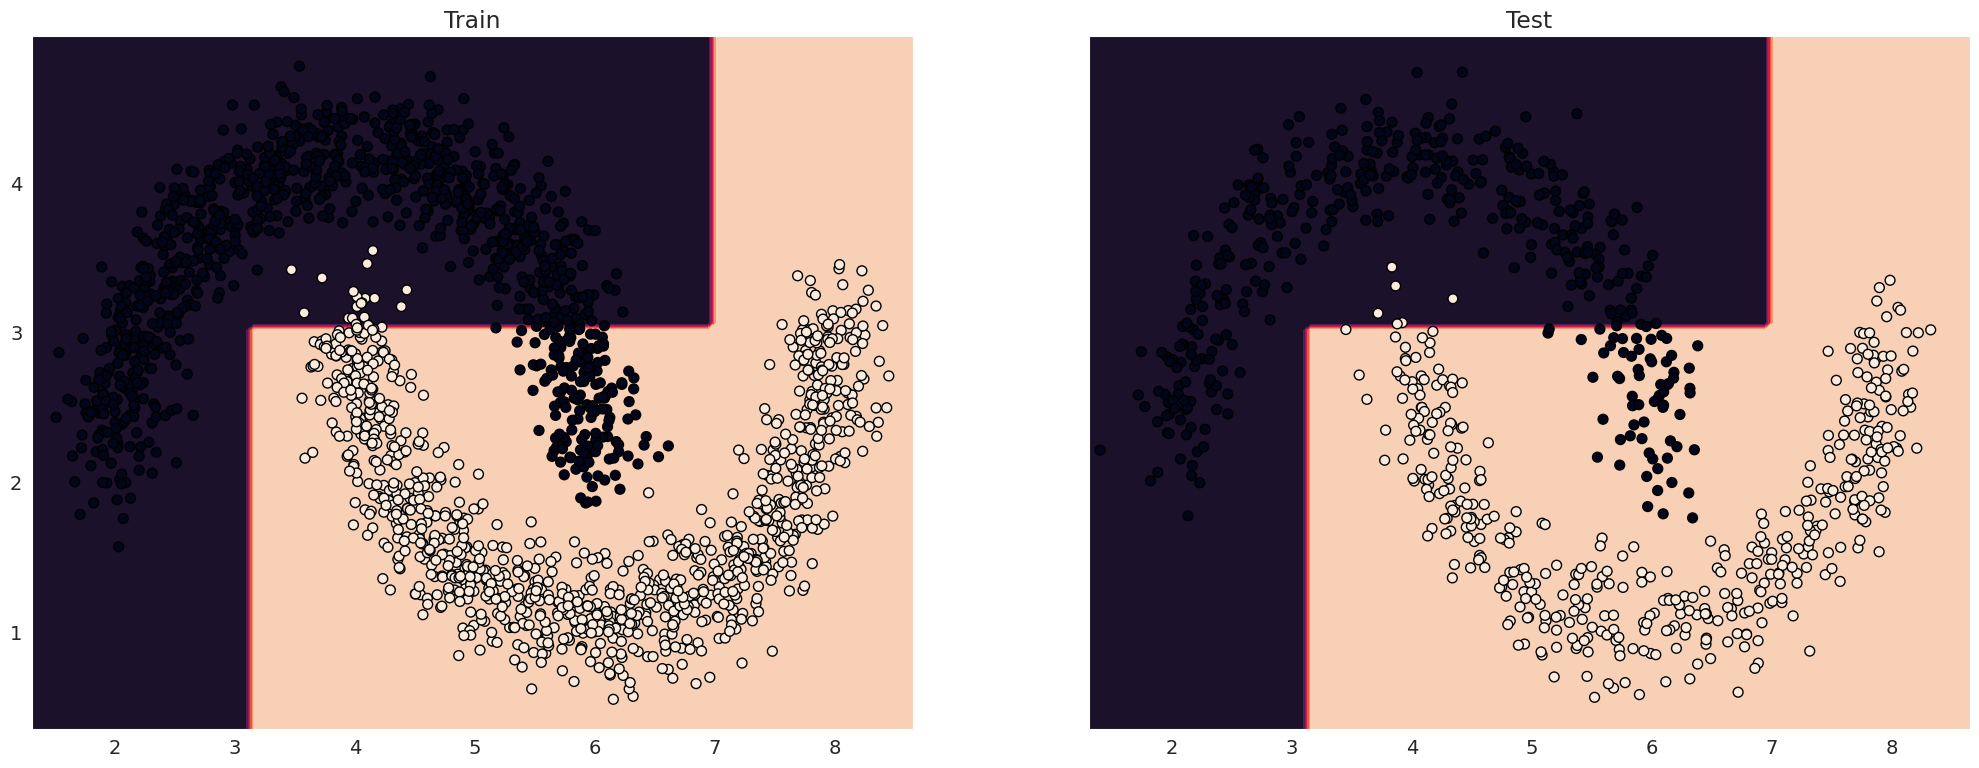

In [14]:
visualize_predictions(dectree, df_train, df_test)

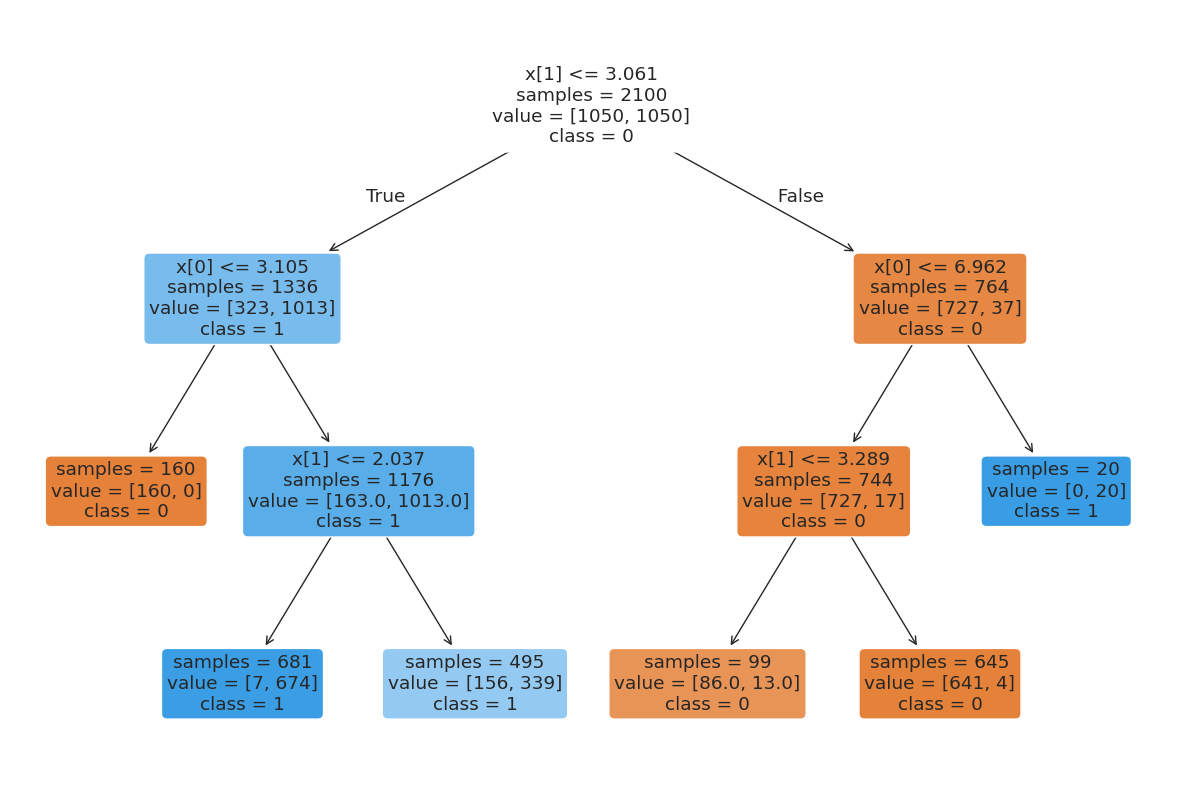

In [15]:
_ = plot_tree(dectree, filled=True, rounded=True, impurity=False, class_names=["0", "1"])

Воот, это уже дерево посерьезнее, тут целых 5 узлов и 6 листов! И так как у нас глубина 3, то мы видим на плоскости принятия решения три кусочка, которые составляют ломаную зону принятия решений.

Таким образом, хоть мы и делаем разделение пространства всего одним числом (прямой линией), мы можем составлять нелинейные разделения пространтва той сложности, как мы хотим. Давайте попробуем глубину побольше!

In [16]:
dectree_more = DecisionTreeClassifier(max_depth=100, random_state=RANDOM_SEED)

dectree_more.fit(x_train, y_train)

y_pred = dectree_more.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       450
           1       0.99      1.00      1.00       450

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


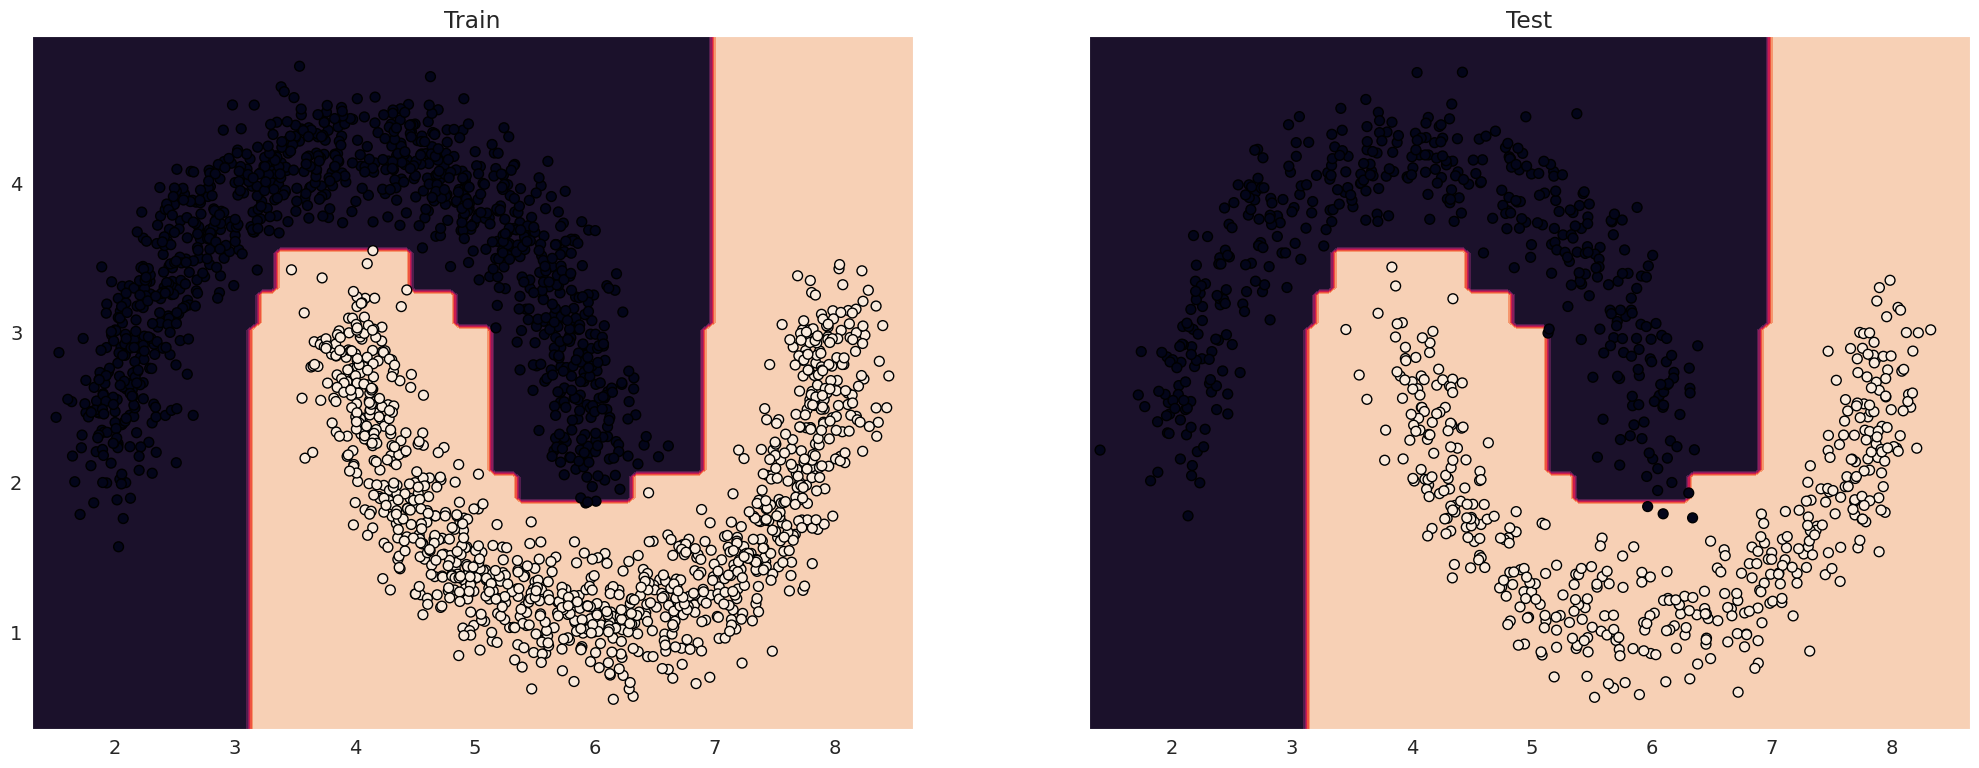

In [17]:
visualize_predictions(dectree_more, df_train, df_test)

Отлично! Видите, и тут добились практически идеального разделения пространства!

Давайте теперь возьмём данные пошумнее и более перемешанные и посмотрим, что будет, если глубина будет слишком высокая:

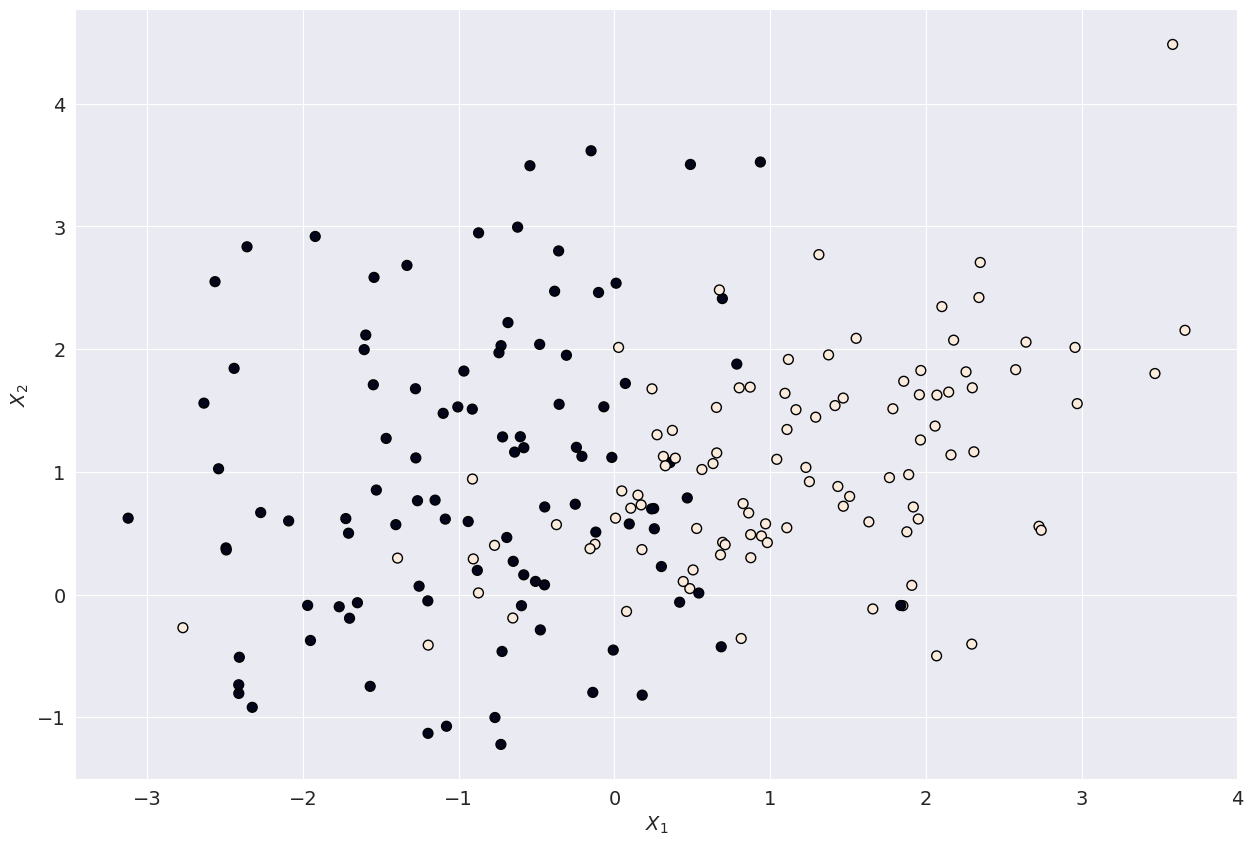

In [18]:
from sklearn.datasets import make_classification

_sample2_X_data, _sample2_y_data = make_classification(
    n_samples=200,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant=0,
    random_state=RANDOM_SEED
)

plt.scatter(_sample2_X_data[:, 0], _sample2_X_data[:, 1], marker="o", c=_sample2_y_data, s=50, edgecolor="k")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()


In [19]:
_smpl2_X_train, _smpl2_X_test, _smpl2_y_train, _smpl2_y_test, = train_test_split(_sample2_X_data, _sample2_y_data, random_state=RANDOM_SEED, stratify=_sample2_y_data, test_size=0.3)

dectree_ovrft = DecisionTreeClassifier(max_depth=int(1e6), random_state=RANDOM_SEED)

dectree_ovrft.fit(_smpl2_X_train, _smpl2_y_train)

y_pred = dectree_ovrft.predict(_smpl2_X_test)
report = classification_report(_smpl2_y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        30
           1       0.83      0.80      0.81        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



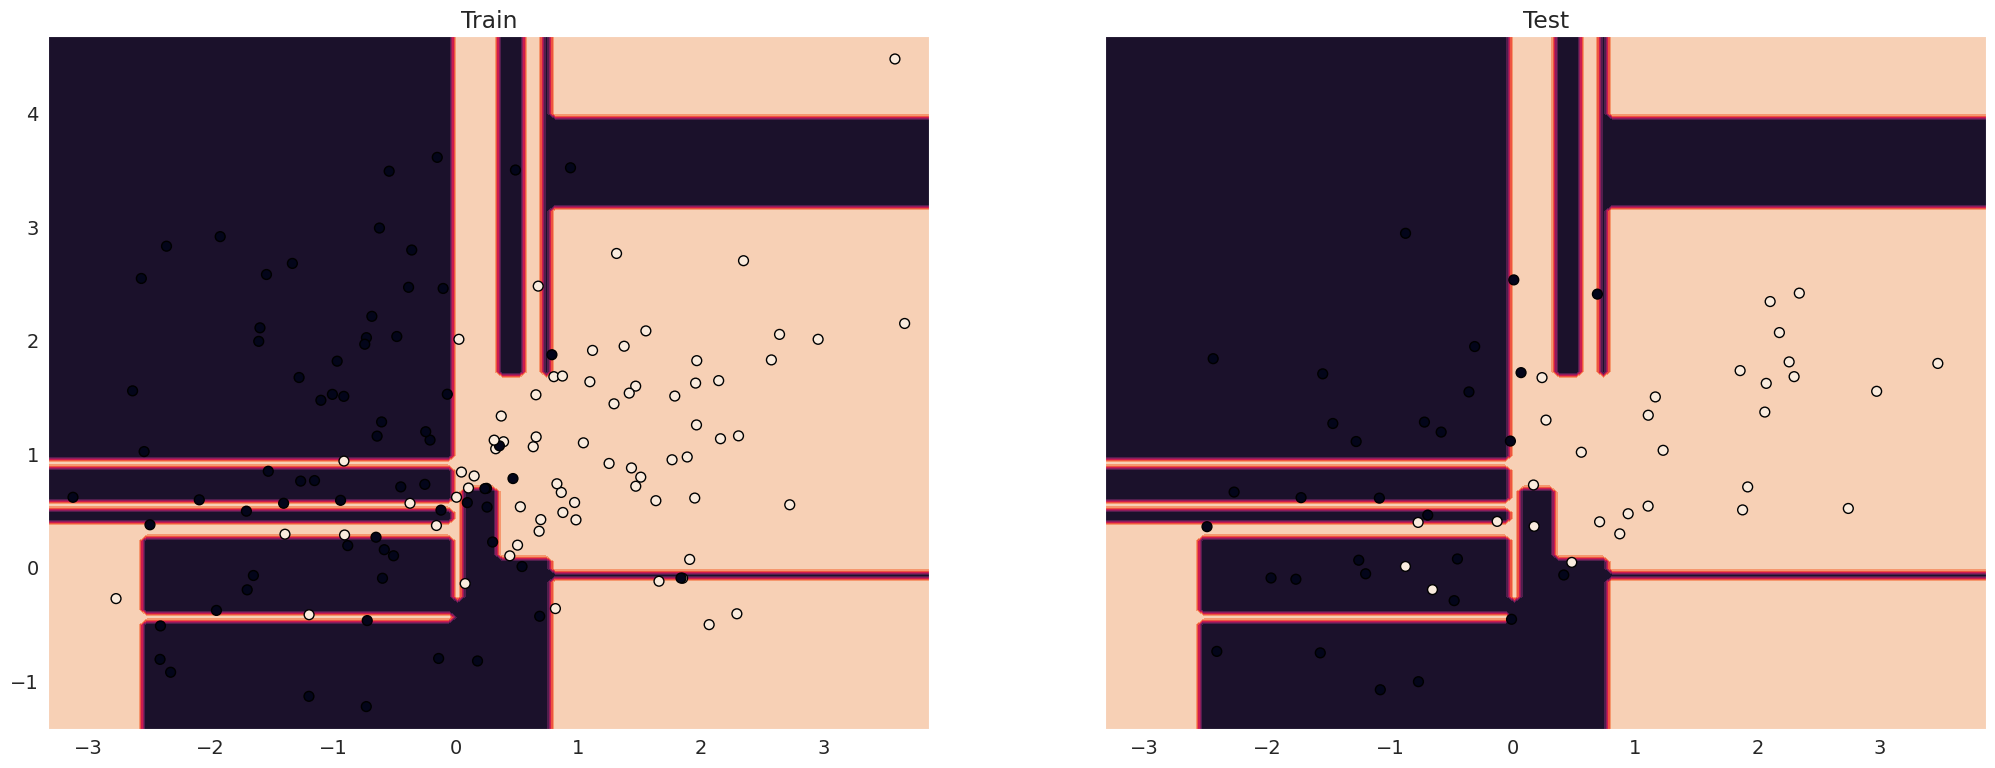

In [20]:
_sample2_df_train = pd.DataFrame(_smpl2_X_train)
_sample2_df_train["target"] = _smpl2_y_train

_sample2_df_test = pd.DataFrame(_smpl2_X_test)
_sample2_df_test["target"] = _smpl2_y_test

visualize_predictions(dectree_ovrft, _sample2_df_train, _sample2_df_test)

Как видно, если не ограничить глубину дерева, то оно постарается разделить пространство так, чтобы каждая точка была в "правильной" области. Это сильно кромсает пространство и не выявляет основную зависимость. Это есть переобучение и **деревья как правило очень сильно ему подвержены**!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/overfitted_tree.jpeg" height=600/></p>

p.s. нарисованное нейросеткой "Переобученное дерево" (=

Но и тут мы можем поиграться с параметрами и получить подходящую глубину, которая нам подойдёт, но из-за простоты линий, слишком малая глубина даст плохие результаты, а слишком высокая - переобучение!

То есть, дерево решений это хорошая модель, которая в отличии от KNN не требует хранить весь набор обучения для предсказания, но она подвержена переобучению, хотя и может описать зависимость практически любой сложности.

Вот бы был алгоритм, который нивелирует переобучение в дереве решения - это было бы идеально, разве нет? Мы бы тогда получили очень хороший как по памяти, так и по нелинейности/сложности алгоритм!

## Ансамблирование

Знаете выражение "один в поле не воин"? Вот мы, держа его в уме, будем думать как бы нам взять не одну модель (дерево решения), а несколько, чтобы их совмещение дало нам лучший результат.

В этом разделе мы изучим два подхода, которые основываются на принципах совмещения нескольких "слабых" моделей.

Обычно под "слабыми" понимаются деревья с небольшой глубиной, порядка 5-7 уровней. Но никто не запрещает брать и другие модели, например, линейную регрессию.

Главное высказывание, на которое мы будем опираться - "несколько слабых моделей могут дать результат лучше, чем одна большая и сложная". Запомним его.

Перейдём теперь к тому, как же их совмещать?

Если мы просто возьмём 20 деревьев и обучим на одной и той же выборке, то это просто нам даст 20 одинаковых деревьев. Секундочку, а зачем?.. Значит, просто так мы не можем совмещать несколько деревьев и нужно разнообразить их обучение.

### Bootstrap - бутстрап

За время разбора алгоритмов вы, возможно, позабыли, что мы работаем с данными...

Данные обычно ассоциируют со статистическими показателями, случайностями и всяким таким. Одним из понятий является *математическое ожидание* какой-то величины. Это есть среднее значение выборки чисел, но по сути, это среднее есть самое ожидаемое по этой выборке значение. То есть, матожидание выборки - это характеристика этой выборки.

Давайте теперь представим, что у нас есть одна выборка - большая такая, примеров на 10000 сэмплов. И вот мы хотим из этой выборки получить 5 других выборок, каждая из которых не похожа на большую выборку, а вот усреднение матожиданий этих пяти выборок давало бы матожидание исходной!

> Зачем нам делать такие махинации?

Да всё просто! Как мы понимаем, просто дублировать выборку нельзя - получится одно и то же. Но если мы получим разные выборки, то модели получатся разные!

> Зачем нам добиваться среднего матожидания этих выборок, как у исходной?

Чтобы модели, хоть и обученные на разных выборках с разным матожиданием, давали такое среднее предсказание, как и модель, обученная на исходной выборке!

> Пусть перед человеком стоит задача: "Прочитать 100 слов и сказать первую пришедшую на ум ассоциацию". Он читает и отвечает: "Пельмени". Если мы найдём пятерых людей, заставим каждого прочитать, например, 30 слов, потом спросим их ассоциации, то сумма их решений должна прийти к пельменям.

Окей, может мы рано заговорили про модели, но давайте посмотрим на то, как магическим образом работает bootstrap:

In [21]:
_sample_set = np.random.default_rng(RANDOM_SEED).integers(low=0, high=1000, size=10000)

print(f"Mean: {_sample_set.mean()}")

Mean: 495.873


Логично, что случайно созданная выборка значений между 0 и 1000 имеет матожидание близкое к 500.

Теперь, создадим 5 бутстрап выборок.

А как их делать? Мы об этом ещё не говорили, но это очень просто!

Представьте, у вас есть корзина из 10 разных шариков - красный, желтый и т.д. И есть 5 других пока что пустых корзин. Вы берёте случайный любой шарик, например, зелёный и кладёте в новую корзину. У вас должно получиться, что есть исходная корзина с 9-ю шариками без зелёного, одна новая с зелёным и 4 пустые. Но не тут то было, зеленый шарик снова появляется в исходной, а в новой он всё так же лежит!

Это называется случайный выбор с возвратом! То есть, из исходной корзины может в первую новую попасть два и больше зелёных и ни одного оранжевого! Процесс же случайный!

Это и зовётся бустрап выборки - те выборки, которые были сделаны с возвратом.

> 🤓 В терминах метода [np.random.Generator.choice()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html?highlight=numpy%20random%20generator%20choice#numpy.random.Generator.choice) это зовется `replace`.

Давайте попробуем сделать 5 бутстрап выборок, и посмотреть на их средние:

In [22]:
rng = np.random.default_rng(RANDOM_SEED)
means = []

for i in range(5):
    means.append(
        rng.choice(_sample_set, replace=True, size=10000).mean()
    )

print(f"Set means: {means}")

Set means: [496.6354, 494.931, 494.0422, 498.1787, 493.5507]


In [23]:
print(f"Mean means: {np.mean(means)}")

Mean means: 495.46759999999995


Как видим, усреднение матожиданий бутстрап выборок даёт действительно матожидание близкое к исходной выборке.

А причём тут модели машинного обучения и ещё раз, какой профит от такого кромсания?

Вообще, модели машинного обучения, если говорить немножко сложнее, стараются повторить статистическое распределение в данных. Усреднение предсказания моделей примерно равно усреднению матожидания этих выборок. А так как наша цель - предсказывать по данным исходной выборки, то бутстрап выборки нам это и гарантируют.

А теперь ещё два приятных момента:
- бустрап, в отличие от выборки без возврата, позволяет создавать выборки нужного размера, а не просто кромсать данные;
- да, деревья решений могут переобучаться, но сами подумайте, если каждый переобучится на своей выборке, то, усреднив результаты, мы получим более менее приличный результат!

Круто, так мы убрали переобучение!

> 🤓 Обучение деревьев происходит на основе алгоритма построения дерева (один из них - [CART](http://pages.stat.wisc.edu/~loh/treeprogs/guide/wires11.pdf)  ~ Classification and regression trees). Построение происходит по принципу поиска наилучших разделений пространства на основе одного из признаков для создания узла и дальнейшего роста.

Ну хватит разговоров - переходим к делу!

Давайте воспользуемся моделью, которая основывается на принципе Bagging (Bootstrap Aggregating) - [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html):

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        30
           1       0.83      0.80      0.81        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



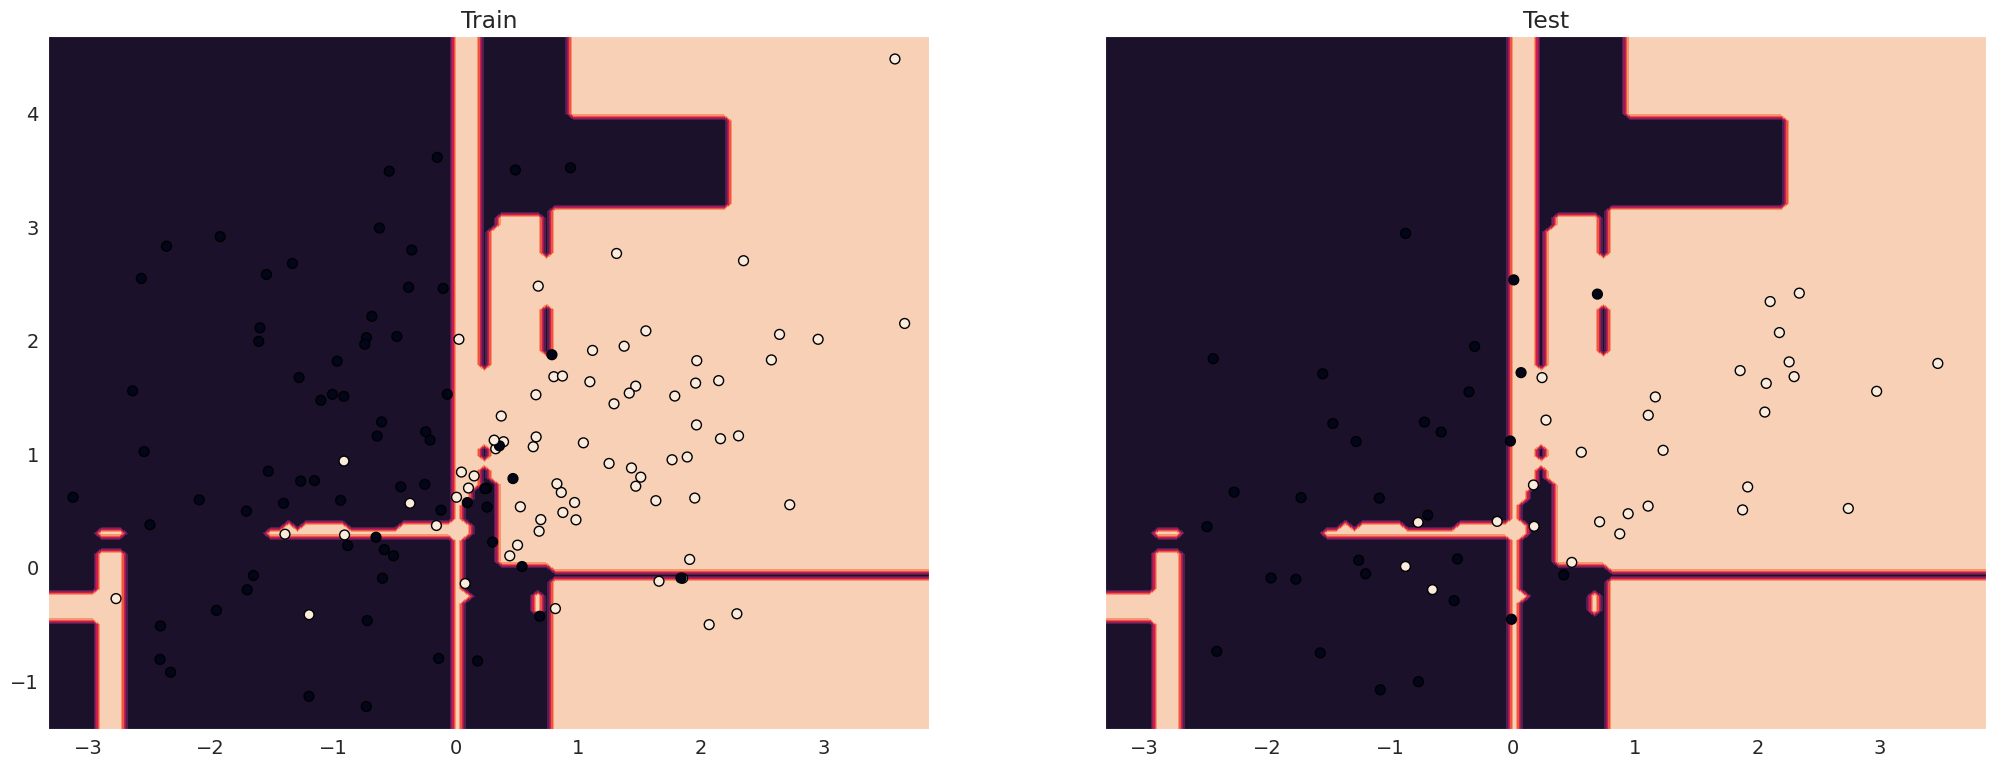

In [24]:
from sklearn.ensemble import BaggingClassifier

base_est = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_SEED)
bagging_clf = BaggingClassifier(base_est, n_estimators=100, random_state=RANDOM_SEED)

bagging_clf.fit(_smpl2_X_train, _smpl2_y_train)

y_pred = bagging_clf.predict(_smpl2_X_test)
report = classification_report(_smpl2_y_test, y_pred)
print(report)

visualize_predictions(bagging_clf, _sample2_df_train, _sample2_df_test)

Здесь мы использовали бэггинг и получили модель, которая даёт похожие метрики, но уже не так сильно переобучается! В ней проявляется более чёткое разделение данных.

Вот так, простой шаг - бустрап выборки и мы получили модель, которая имеет явные плюсы за счёт совмещения нескольких простых моделей! Давайте для закрепления посмотрим на картинку, объясняющую принцип работы:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/31_boosting.png" width=800/></p>

Мы забыли обсудить, как делается голосование!

Самый простой вариант - по большинству голосов за конкретный класс. Вот у вас 100 деревьев и 90 предсказывают класс 1, а 10 остальных - 0. Как думаете, какой логичнее выбрать? =)

> 🔥 Бывают ситуации, когда голосование моделей надо проводить с учётом весов. Например, когда вы пытаетесь объединить три модели в ансамбль, при этом первая работает очень хорошо, но две другие похуже - вы же будете доверять больше первой, так? Значит, можно голосу первой модели присвоить бОльший вес и тогда это может улучшить результаты предсказаний!

### Random Forest - Случайный лес

Вот мы вроде получили метод работы со множеством деревьев путём специального способа формирования выборок. Тем не менее, просто набор моделей на основе таких выборок всё ещё даёт повод для переобучения, так как мы хоть и создали разные выборки, но деревья решений при поиске лучшего узла для формирования проверяют все признаки и пытаются выбрать лучшее.

Модель **случайного леса** в отличии от бэгинга над деревьями решений отличается простым трюком! Вот дерево при построении пробегает по всем признакам и пробует разные значения порогов, чтобы выбрать, какой же даст улучшение метрики. А давайте теперь каждое дерево будет пробовать не все признаки, а лишь часть из них!

То есть, например, в данных есть 10 признаков. Вот мы сделали 100 бутстрап выборок для обучения 100 деревьев. А теперь каждое дерево при обучении для формирования новых узлов будет просматривать не все 10 признаков, а всего 3 случайных признака! Так мы ещё сильнее разнообразим формирование каждого дерева и это даст большее разнообразие, что повлияет на то, как модель леса обучается.

> ⚠️ Для классификации количество случайных признаков берется как $\sqrt{M}$, где $M$ - количество исходных признаков

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.86      0.83      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



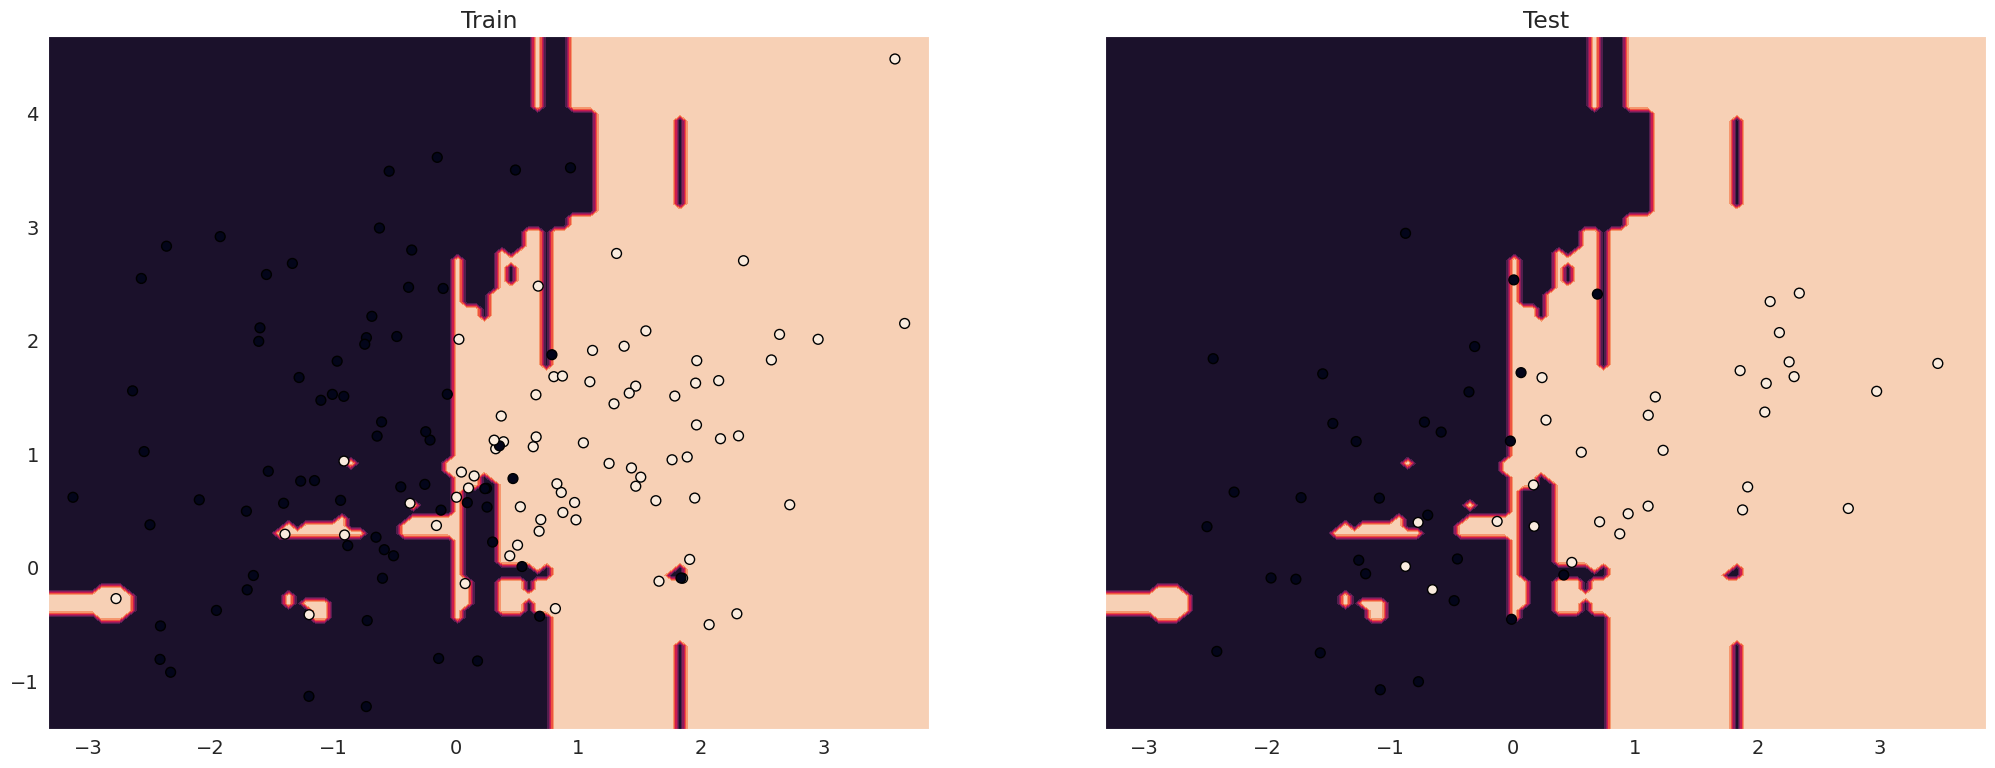

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=1, random_state=RANDOM_SEED)

rf_clf.fit(_smpl2_X_train, _smpl2_y_train)

y_pred = rf_clf.predict(_smpl2_X_test)
report = classification_report(_smpl2_y_test, y_pred)
print(report)

visualize_predictions(rf_clf, _sample2_df_train, _sample2_df_test)

> ⚠️ Получается, что случайный лес - это не просто бэггинг, а ещё и случайный выбор признаков из всех.

И, вуаля! Метрики выросли, а разделение пространства стало ещё менее разорванным. Проглядывается общая тенденция распределения точек.

Вот так вот просто мы изучили, как на практике работает один из методов ансамблирования на основе бэггинга и немного обсудили тонкости внутренней работы!

### Boosting - бустинг

Вот мы рассмотрели метод, когда мы параллельно обучаем несколько деревьев, а затем голосованием принимаем конечно решение. Это один из принципиальных способов организации ансамблей моделей.

Другой способ организует ансамбль последовательно. Как это??

Ну вот представьте, что вы учите очень простую модель делать предсказания. Какая самая простая модель в регресии? А какая в классификации?

> ✨ Подумайте и обсудите с преподавателем

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/think_about_it_image.png" width=600/></p>

Если вы ответили, что в регрессии самая простая модель - среднее значение, а в классификации - константная модель, которая предсказывает тот класс, которого большинство, то вы абсолютно правы!

Мы можем сделать простую модель, даже тот же пенёк (короткое дерево с глубиной 1) и делать предсказания.

Вот пенёк делает предсказания, но ведь он частенько ошибается. Такая простая модель на достаточно сложных данных будет иметь крайне низкую точность...

Что мы можем сделать? Поменять пенёк на модель посложнее? Да, это рабочий вариант, но мы говорим об ансамблях, а это просто смена модели.

Вот бы было круто иметь модель, которая исправляет ошибки нашей маленькой модели.

Стоп-стоп, что? Что значит исправляет ошибки? Откуда во время предсказания мы знаем, что мы сделали или нет ошибку? Разметки же нет?

Всё верно, если вы подумали так же, *исправление ошибок* относится к стадии обучения. По сути, если лес учит кучу деревьев параллельно, просто на разных выборках, то бустинг обучается сложнее.

* Сначала мы берём простую модель, которая уже обучена на выборке.
* Далее мы делаем предсказания на обучающей выборке и смотрим, где мы промахнулись. Промахи - это отличия предсказанной степени уверенности от целевой. Например, класс "Хорошо" - это степень уверенности 1, а модель предсказывает 0.2, значит разница = 0.8.
* После вычисления ошибок мы обучаем новую модель, цель которой предсказывать не конечные классы, а ошибки! То есть, если первая модель пытается предсказать конечные классы, то вторая и последующие модели ориентируются на величины ошибок предыдущих и пытаются предсказывать именно их, чтобы нивелировать!
* После всего процесса обучения у нас получается куча простых моделей, сложение которых даёт осознанное предсказание, так как первая простая модель сделала пусть и не очень хорошее предсказание, но все остальные обучены корректировать это предсказание и предсказание других.

Бум! Вот так вот! Представляете, в ML можно не только обучать модели предсказывтаь классы, но и обучать модели поправлять другие модели! Круто!

Сравнение методик можно представить вот так:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/31_methods.png" height=1000/></p>

Ну что ж, пора попробовать это в деле!

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        30
           1       0.83      0.80      0.81        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



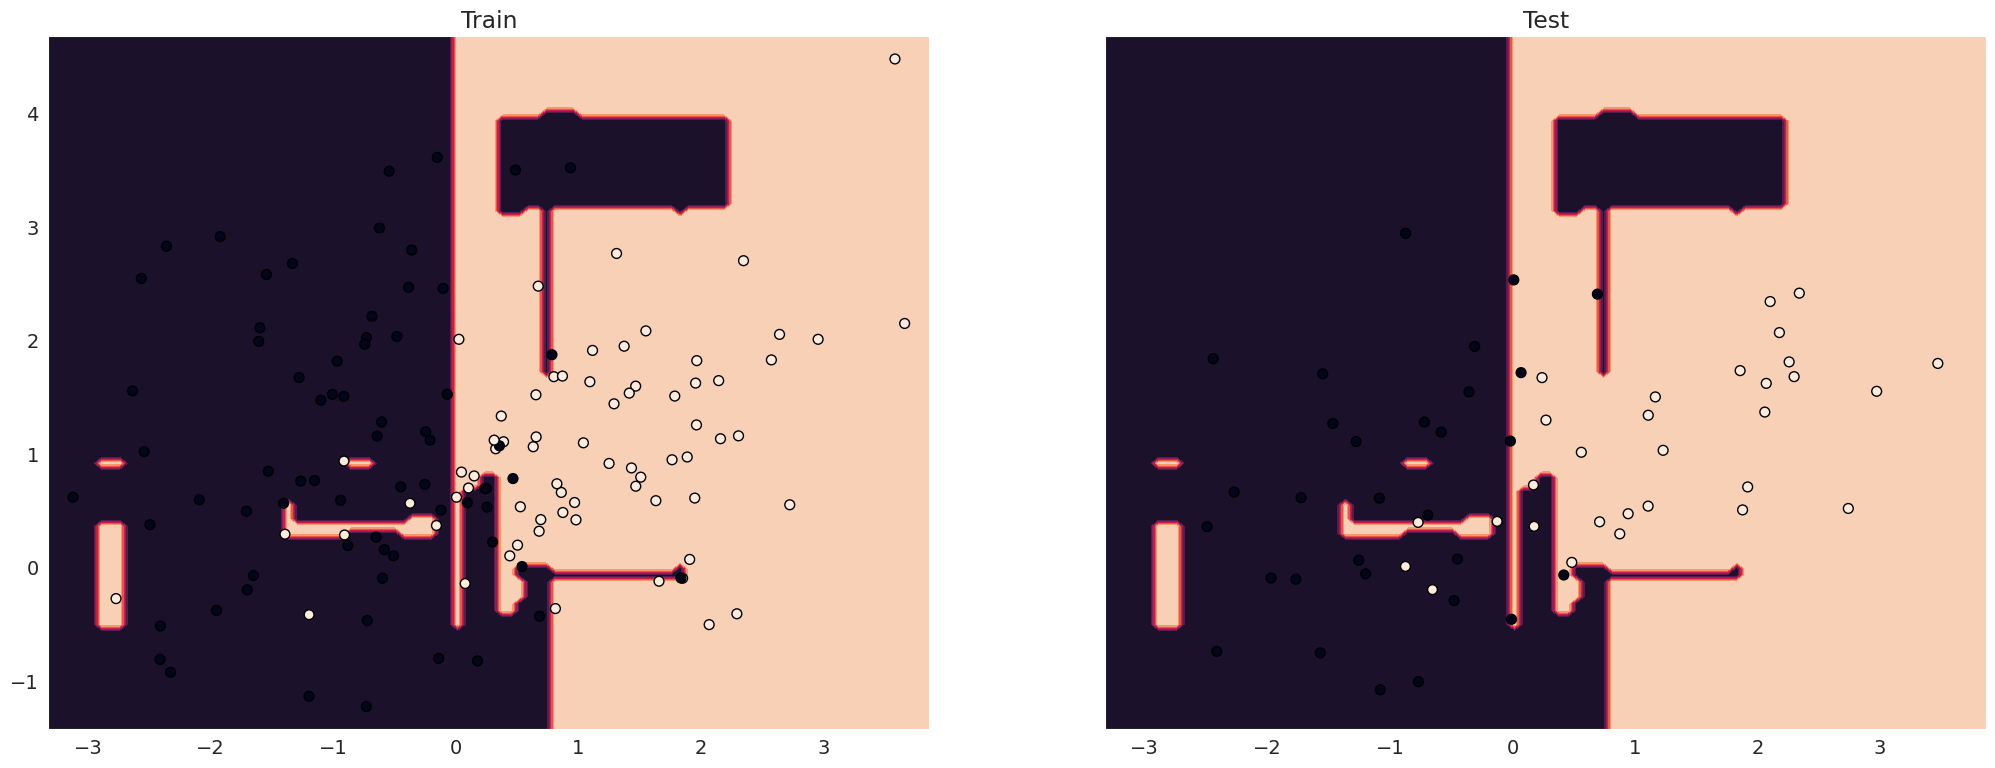

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=30, max_depth=5, max_features=1, random_state=RANDOM_SEED)

gb_clf.fit(_smpl2_X_train, _smpl2_y_train)

y_pred = gb_clf.predict(_smpl2_X_test)
report = classification_report(_smpl2_y_test, y_pred)
print(report)

visualize_predictions(gb_clf, _sample2_df_train, _sample2_df_test)

Как видите, модель работает лучше, чем просто обученное дерево решений, но у неё есть явная проблема, которую важно понимать:
> **Она тоже подвержена переобучению, так как мы можем до бесконечности наращивать деревья, чтобы улучшать предсказания =(**

Но так как модель бустинга - это ансамбль простых моделей (деревьев), то при аналогичной сложности модели можно добиться лучших результатов, чем применяя простые деревья!

> ⚠️ Обратите внимание, что случайный лес - это статистическое усреднение, что слабо подвержено переобучению, в свою очередь бустинг - это инкрементное улучшение, что можно довести до слишком точного запоминания обучающей выборки (переобучение)

> ⚠️ Все представленные модели и их параметры выбраны без специального подбора. Говоря про тенденцию к переобучению - всё зависит от параметров. Главное понимать, что настройка параметров имеет достаточно важную роль в построении стабильной модели.

Вот так нехитро мы познакомились с двумя методами ансамблирования слабых моделей для достижения лучшего результата! Пополнив свой инструментарий, можно в скором времени приступать к очень серьезной задачке!

> 🚀 Говоря о реальном применении, бустинг является очень популярной методикой, поэтому сегодня реализация sklearn применяется редко - чаще используются модификации базового метода: [XGBoost](https://xgboost.readthedocs.io/en/latest/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/), [CatBoost](https://catboost.ai/).

### Stacking - стэкинг

В методах ансамблирования существует также методика Stacking, которая представляет собой в прямом cмысле совмещение моделей параллельно. Только каждая представляет собой простую модель разного типа. Результаты предсказания поступают на ещё одну модель, которая по предсказаниям первых моделей учится правильно делать конечное предсказание. Выглядит это примерно так:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/31_stacking.png" width=800/></p>

На практике используется реже, но так как вы уже освоили два основных метода ансамблирования, то и этот вам покажется простым, тем более в sklearn уже есть реализация [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html).

## Вопросы для закрепления

А теперь пара вопросов, чтобы закрепить материал!

1. Почему KNN не пользуется сейчас большой популярностью?
2. Как принять решение, если в KNN, К = 4, 2 соседа говорят 1, а другие 2 соседа говорят 0?  
3. Что будет, если в случайный лес запихнуть одинаковые пеньки и подать на них одинаковые выборки?
4. Можно ли использовать случайный лес для решения задачи регрессии?
5. В чём главное отличие бэггинга от бустинга?


## Полезные ссылки
* [KNN от StatQuest](https://www.youtube.com/watch?v=HVXime0nQeI)
* [K-means clustering от StatQuest](https://www.youtube.com/watch?v=4b5d3muPQmA)
* [Decision Trees от StatQuest](https://www.youtube.com/watch?v=7VeUPuFGJHk)
* [Decision Trees in Python from Start to Finish от StatQuest](https://www.youtube.com/watch?v=q90UDEgYqeI)
* [Bootstrapping Main Ideas от StatQuest](https://www.youtube.com/watch?v=Xz0x-8-cgaQ)
* [Random Forest (Part 1) от StatQuest](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ)
* [Random Forest (Part 2) - Missing data and clustering от StatQuest](https://www.youtube.com/watch?v=nyxTdL_4Q-Q)
* [Gradient Boost (Part 1) - Regression Main Ideas от StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&t=746s)
* [Gradient Boost (Part 2) - Regression Details от StatQuest](https://www.youtube.com/watch?v=2xudPOBz-vs)
* [Gradient Boost (Part 3) - Classification от StatQuest](https://www.youtube.com/watch?v=jxuNLH5dXCs)
* [Gradient Boost (Part 4) - Classification Details от StatQuest](https://www.youtube.com/watch?v=StWY5QWMXCw)
* [XGBoost (Part 1) - Regression от StatQuest от StatQuest](https://www.youtube.com/watch?v=OtD8wVaFm6E)
* [XGBoost (Part 2) - Classification от StatQuest](https://www.youtube.com/watch?v=8b1JEDvenQU)
* [XGBoost (Part 3) - Mathematical Details от StatQuest](https://www.youtube.com/watch?v=ZVFeW798-2I)
* [XGBoost (Part 4) - Crazy Cool Optimizations от StatQuest](https://www.youtube.com/watch?v=oRrKeUCEbq8)
* [XGBoost in Python from Start to Finish от StatQuest](https://www.youtube.com/watch?v=GrJP9FLV3FE)
